# Keras Prediction
4 2D CNN Convolutional Layer
---

Credits:
- https://www.kaggle.com/ejlok1/audio-emotion-part-6-2d-cnn-66-accuracy

In [9]:
# Credit to:
# https://www.kaggle.com/ejlok1/audio-emotion-part-6-2d-cnn-66-accuracy

# Keras
from keras.utils import np_utils, to_categorical

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import numpy as np
import pandas as pd
import os

# Local
from source_pytorch.kerasLoader import KerasLoader
from source_pytorch.kerasCnnModel import KerasCnnModel
from source_pytorch.kerasResultTools import Get_results

In [10]:
#Set the parameters and load the data
setting = {
  "audio_duration"  :   4,
  "n_mfcc"          :   40,
  "sampling_rate"   :   44100,
  "audio_duration"  :   4,
  "dataroot"        :   "AudioDataset",
  "batch_size"      :   10,
  "epochs"          :   5
}

In [11]:
#Get the reference
ref = pd.read_csv("./ReferenceData.csv")[:200]
#Print head / test successfull load
ref.head()

,label,fname
0,fearful,03-01-06-01-02-02-02.wav
1,angry,03-01-05-01-02-01-16.wav
2,surprise,03-01-08-01-01-01-14.wav
3,fearful,03-01-06-01-02-02-16.wav
4,angry,03-01-05-01-02-01-02.wav


In [12]:
#Split the Train and Test dataset
X_train, X_test, y_train, y_test = train_test_split(ref["fname"]
                                                    ,ref["label"]
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=50
                                                   )
#Split the Train and Validation dataset
X_train, X_valid , y_train, y_valid = train_test_split(X_train
                                                    , y_train
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=50
                                                   )


#Merge data and prediction in 1 dataset for train validation and test
train_df = pd.concat([X_train,y_train], axis = 1)  
valid_df =  pd.concat([X_valid,y_valid], axis = 1)
test_df = pd.concat([X_test,y_test], axis = 1)

print('Dataset Len:\t Train - {} \tValid Dataset - {} \tTest Dataset - {}'.format(len(train_df), len(valid_df), len(test_df)))

Dataset Len:	 Train - 112 	Valid Dataset - 38 	Test Dataset - 50


In [13]:
train_mfcc = KerasLoader().prepare_data(train_df,setting["n_mfcc"],setting["sampling_rate"], setting["audio_duration"], dataroot = setting["dataroot"] )
valid_mfcc = KerasLoader().prepare_data(valid_df,setting["n_mfcc"],setting["sampling_rate"], setting["audio_duration"], dataroot = setting["dataroot"] )
test_mfcc = KerasLoader().prepare_data(test_df,setting["n_mfcc"],setting["sampling_rate"], setting["audio_duration"], dataroot = setting["dataroot"] )

100%|██████████| 50/50 [00:03<00:00, 14.64it/s]


In [14]:
# One hot encode the target 
lb = LabelEncoder()
y_train_converted = np_utils.to_categorical(lb.fit_transform(y_train))
y_valid_converted = np_utils.to_categorical(lb.fit_transform(y_valid))
y_test_converted = np_utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
mean = np.mean(train_mfcc, axis=0)
std = np.std(train_mfcc, axis=0)

X_train_norm = (train_mfcc - mean)/std
X_valid_norm = (valid_mfcc - mean)/std
X_test_norm = (test_mfcc - mean)/std

In [15]:
%%time

# Build CNN model 
model = KerasCnnModel().load(n=setting["n_mfcc"])

#Fit and Valid the data
model_history = model.fit(X_train_norm, y_train_converted, validation_data=(X_valid_norm, y_valid_converted), 
                    batch_size=setting["batch_size"], verbose = 2, epochs=setting["epochs"])

Train on 112 samples, validate on 38 samples
Epoch 1/5
 - 14s - loss: 2.4818 - acc: 0.1607 - val_loss: 2.6580 - val_acc: 0.2368
Epoch 2/5
 - 11s - loss: 2.1824 - acc: 0.2054 - val_loss: 2.1210 - val_acc: 0.3947
Epoch 3/5
 - 11s - loss: 2.0699 - acc: 0.2054 - val_loss: 2.2501 - val_acc: 0.3684
Epoch 4/5
 - 13s - loss: 2.0319 - acc: 0.2054 - val_loss: 2.0272 - val_acc: 0.3684
Epoch 5/5
 - 13s - loss: 1.9978 - acc: 0.2589 - val_loss: 1.9050 - val_acc: 0.3947
CPU times: user 2min 5s, sys: 20.4 s, total: 2min 26s
Wall time: 1min 4s


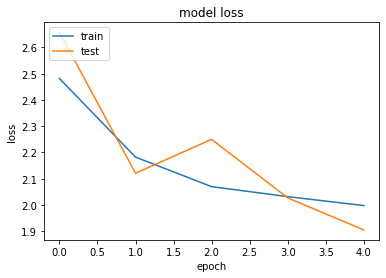

acc: 26.00%


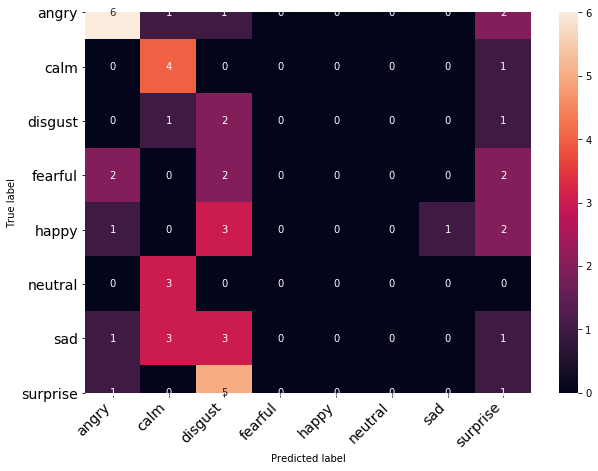

In [16]:
#Show the result
results = Get_results(model_history,model,X_test_norm ,y_test_converted, ref.label.unique())
results.create_plot(model_history)
results.create_results(model,X_test_norm, y_test_converted)
results.confusion_results(X_test_norm, y_test_converted, ref.label.unique(), model,lb)